# Implementing a Convolutional Neural Network
In this Jupyter Notebook we will implement a Convolutional Neural Network to classify images of cats and dogs.

In [1]:
import numpy as np

In [2]:
import tensorflow as tf
from tensorflow import keras

In [3]:
# Image processing
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [4]:
# We will use the RMSprop optimizer, but you can try others like SGD and Adam
#from tensorflow.keras.optimizers import SGD
#from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import RMSprop

# Since we have two classes we will use as our loss function the Binary Cross Entropy
from tensorflow.keras.losses import BinaryCrossentropy

In [5]:
# We will aim for banary accuracy as evaluation metric
from tensorflow.keras.metrics import binary_accuracy

In [6]:
# Model Checkpoint
from tensorflow.keras.callbacks import ModelCheckpoint

## Load an image from de dataset
It is a good idea to load an image from our dataset to see how it looks.

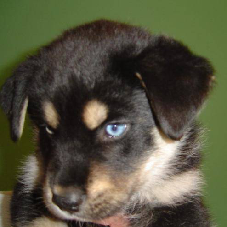

In [7]:
train_path = 'dataset/train/'
file = train_path + 'dog/dog.998.jpg'

image_shape = 227

load_img(file, target_size=(image_shape,image_shape))

## Data preparation
To prepare our data we use an `ImageDataGenerator` object that allow us to do image transformation on the whole dataset. We split our data into `train` and `validation`.

In [8]:
train_gen = ImageDataGenerator(rescale=1./255)

train_ds = train_gen.flow_from_directory(
    'dataset/train/',
    target_size=(image_shape, image_shape),
    batch_size=64,
    shuffle=True,
    class_mode='binary')


val_gen = ImageDataGenerator(rescale=1./255)

val_ds = val_gen.flow_from_directory(
    'dataset/validation/',
    target_size=(image_shape, image_shape),
    batch_size=64,
    shuffle=True,
    class_mode='binary')

Found 20000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.


## Checkpoint
Checkpointing is usefull if we want to do early stoppage when our model has trained with enough accuracy. We will keep track of the `validation accuracy` of our model, and store the one with the best results.

In [9]:
checkpoint = ModelCheckpoint(
    'checkpoints/cat_dog_classifier{epoch:02d}_{val_binary_accuracy:.3f}.h5',
    save_best_only=True, 
    monitor='val_binary_accuracy', 
    mode='max')

## Convolutional Neural Network
We will define a CNN with the following architecture. 

![CNN](images/model.png)


In [10]:
image_shape = 227

inputs = tf.keras.layers.Input(shape=(image_shape,image_shape,3))

conv_1 = tf.keras.layers.Conv2D(filters=64, kernel_size=3, strides=2, activation='relu')(inputs)
pool_1 = tf.keras.layers.MaxPool2D(pool_size=5, strides=2)(conv_1)
batch_1 = tf.keras.layers.BatchNormalization()(pool_1)

conv_2 = tf.keras.layers.Conv2D(filters=16, kernel_size=5, strides=2, activation='relu')(batch_1)
pool_2 = tf.keras.layers.MaxPool2D(pool_size=5, strides=2)(conv_2)
batch_2 = tf.keras.layers.BatchNormalization()(pool_2)

flatten_1 = tf.keras.layers.Flatten()(batch_2)

dense_1 = tf.keras.layers.Dense(500, activation='relu')(flatten_1)
drop_1 = tf.keras.layers.Dropout(0.5)(dense_1)

dense_2 = tf.keras.layers.Dense(100, activation='relu')(drop_1)
drop_2 = tf.keras.layers.Dropout(0.5)(dense_2)

dense_3 = tf.keras.layers.Dense(50, activation='relu')(drop_2)
drop_3 = tf.keras.layers.Dropout(0.5)(dense_3)

dense_4 = tf.keras.layers.Dense(5, activation='relu')(drop_3)
drop_4 = tf.keras.layers.Dropout(0.5)(dense_4)

outputs = tf.keras.layers.Dense(1, activation='sigmoid')(drop_4)

model = tf.keras.Model(inputs, outputs)

2022-10-26 11:24:37.128842: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-26 11:24:37.136774: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-26 11:24:37.137155: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-26 11:24:37.138215: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [11]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 227, 227, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 113, 113, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 55, 55, 64)       0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 55, 55, 64)       256       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 26, 26, 16)        25616     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 11, 11, 16)       0     

In [12]:
# Set the optimizer
#optimizer = SGD(learning_rate=0.02, momentum=0.8)
#optimizer = Adam(learning_rate=0.01)
optimizer = RMSprop()

# Loss function cross entropy for binary data
loss = BinaryCrossentropy(from_logits=False)

In [13]:
# Compile the model for training
model.compile(optimizer=optimizer, loss=loss, metrics=['binary_accuracy'])

## Train the model
In this part we will train our model using the `fit` method from our `model`. We will train for `20` `epochs` with a `batchsize` of `64`.

In [14]:
history = model.fit(train_ds, epochs=20, validation_data=val_ds, validation_steps=50, callbacks=[checkpoint])

Epoch 1/20


2022-10-26 11:24:39.636384: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8101


313/313 [==============================] - 80s 248ms/step - loss: 0.7874 - binary_accuracy: 0.4992 - val_loss: 0.6937 - val_binary_accuracy: 0.4959
Epoch 2/20
313/313 [==============================] - 74s 238ms/step - loss: 0.7053 - binary_accuracy: 0.5005 - val_loss: 0.6934 - val_binary_accuracy: 0.4934
Epoch 3/20
313/313 [==============================] - 75s 239ms/step - loss: 0.7019 - binary_accuracy: 0.4988 - val_loss: 0.6933 - val_binary_accuracy: 0.4959
Epoch 4/20
313/313 [==============================] - 74s 237ms/step - loss: 0.6978 - binary_accuracy: 0.4990 - val_loss: 0.6932 - val_binary_accuracy: 0.4969
Epoch 5/20
313/313 [==============================] - 71s 228ms/step - loss: 0.6993 - binary_accuracy: 0.5049 - val_loss: 0.6930 - val_binary_accuracy: 0.5106
Epoch 6/20
313/313 [==============================] - 72s 231ms/step - loss: 0.6974 - binary_accuracy: 0.4955 - val_loss: 0.6931 - val_binary_accuracy: 0.5031
Epoch 7/20
313/313 [==============================] - 71s

## Evaluation:
We can assess the performance of our model by comparing the training and validation accuracy.

In [15]:
import matplotlib.pyplot as plt

In [16]:
train_acc = history.history['binary_accuracy']
val_acc = history.history['val_binary_accuracy']

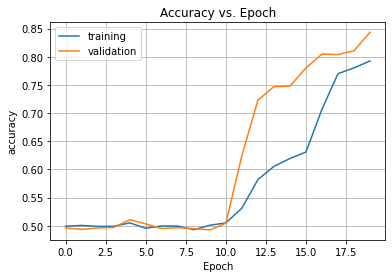

In [17]:
plt.plot(train_acc, label='training')
plt.plot(val_acc, label='validation')
plt.xlabel('Epoch')
plt.ylabel('accuracy')
plt.grid('on')
plt.title('Accuracy vs. Epoch')
plt.legend()
plt.show()